# Soil Moisture Active Passive (SMAP) Level 4 Data demo for Mato Grosso (Brazil)
In this demo we are downloading data using Planet OS Package-API which let's us use bigger amount of data with less time than raster API. 

In [1]:
%matplotlib inline
import time
import os
from package_api import download_data
import xarray as xr
from netCDF4 import Dataset, num2date
from mpl_toolkits.basemap import Basemap
import datetime
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import warnings
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

<font color='red'>Please put your datahub API key into a file called APIKEY and place it to the notebook folder or assign your API key directly to the variable API_key!</font>

In [2]:
API_key = open('APIKEY').read().strip()

Here we define the area we are intrested, time range from where we want to have the data, dataset key to use and variable name.

In [3]:
latitude_north = 5.8; latitude_south = -32
longitude_west = -73; longitude_east = -33

area = 'brazil'
date = datetime.datetime.now() - datetime.timedelta(days=10)
time_start = date.strftime('%Y-%m-%d') + 'T16:00:00'
time_end = date.strftime('%Y-%m-%d') + 'T19:00:00' 
dataset_key = 'nasa_smap_spl4smau'
variable = 'Analysis_Data_sm_surface_analysis'

This one here is generating working directory, we need it to know where we are going to save data. No worries, we will delete file after using it! 

In [4]:
folder = os.path.realpath('.') + '/'

Now we ara making a function for making images 

In [5]:
def make_image(lon,lat,data,date,latitude_north, latitude_south,longitude_west, longitude_east,unit,**kwargs):
    m = Basemap(projection='merc', lat_0 = 55, lon_0 = -4,
         resolution = 'i', area_thresh = 0.05,
         llcrnrlon=longitude_west, llcrnrlat=latitude_south,
         urcrnrlon=longitude_east, urcrnrlat=latitude_north)
    lons,lats = np.meshgrid(lon,lat)
    lonmap,latmap = m(lons,lats)
    
    if len(kwargs) > 0:
        fig=plt.figure(figsize=(10,8))
        plt.subplot(221)
        m.drawcoastlines()
        m.drawcountries()
        c = m.pcolormesh(lonmap,latmap,data,vmin = 0.01,vmax = 0.35)
        plt.title(date)
        
        plt.subplot(222)
        m.drawcoastlines()
        m.drawcountries()
        plt.title(kwargs['date_later'])
        m.pcolormesh(lonmap,latmap,kwargs['data_later'],vmin = 0.01,vmax = 0.35)
        
        
        
    else:
        fig=plt.figure(figsize=(9,7))
        m.drawcoastlines()
        m.drawcountries()
        c = m.pcolormesh(lonmap,latmap,data,vmin = 0.01,vmax = 0.35)
        plt.title(date)
    
    cbar = plt.colorbar(c)
    cbar.set_label(unit)
    plt.show()

Here we are downloading data by using Package-API. If you are intrested how data is downloaded, find the file named `package_api.py` from notebook folder.

In [6]:
package_key = download_data(folder,dataset_key,API_key,longitude_west,longitude_east,latitude_south,latitude_north,time_start,time_end,variable,area)

https://api.planetos.com/v1/packages?dataset=nasa_smap_spl4smau&apikey=8428878e4b944abeb84790e832c633fc&polygon=[[-73,-32],[-33,-32],[-33,5.8],[-73,5.8],[-73,-32]]&grouping=location&reftime_recent=true&time_start=2018-04-29T16:00:00&time_end=2018-04-29T19:00:00&package=nasa_smap_spl4smau_20180429T160000to20180429T190000_brazil&var=Analysis_Data_sm_surface_analysis&count=1000
https://api.planetos.com/v1/packages/nasa_smap_spl4smau_20180429T160000to20180429T190000_brazil?apikey=8428878e4b944abeb84790e832c633fc
https://api.planetos.com/v1/packages/nasa_smap_spl4smau_20180429T160000to20180429T190000_brazil/data?apikey=8428878e4b944abeb84790e832c633fc
Data is downloaded!


Now we have data and we are reading it in using xarray:

In [7]:
filename_s_america = package_key + '.nc'
data = xr.open_dataset(filename_s_america,decode_cf=False)
del (data['Analysis_Data_sm_surface_analysis'].attrs['missing_value'])
data = xr.conventions.decode_cf(data)
surface_soil_moisture_data = data.Analysis_Data_sm_surface_analysis
unit = surface_soil_moisture_data.units
surface_soil_moisture = data.Analysis_Data_sm_surface_analysis.values[0,:,:]
surface_soil_moisture= np.ma.masked_where(np.isnan(surface_soil_moisture),surface_soil_moisture)

latitude = data.lat; longitude = data.lon
lat = latitude.values
lon = longitude.values
date = str(data.time.values[0])[:-10]

Here we are making image by using function defined above. 

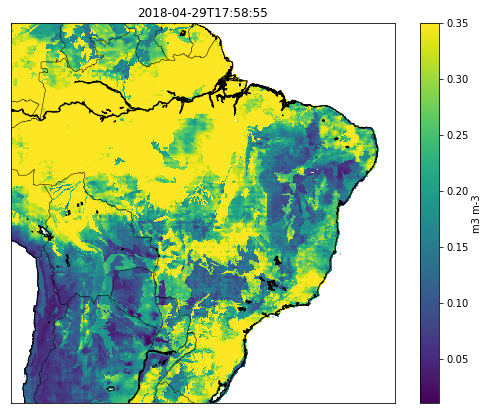

In [8]:
make_image(lon,lat,surface_soil_moisture,date,latitude_north, latitude_south,longitude_west, longitude_east,unit)

So let's see Mato Grosso littlebit closer. For that we need to define the area and we will slice data from this area. 

In [9]:
grosso_west = -61.6; grosso_east = -50.2
grosso_south = -18; grosso_north = -7.2

lon_gr = longitude.sel(lon=slice(grosso_west,grosso_east)).values
lat_gr = latitude.sel(lat=slice(grosso_north,grosso_south)).values
soil_gr = surface_soil_moisture_data.sel(lat=slice(grosso_north,grosso_south),lon=slice(grosso_west,grosso_east)).values[0,:,:]
soil_gr = np.ma.masked_where(np.isnan(soil_gr),soil_gr)

Let's also import some data from closer today

In [10]:
date_later = datetime.datetime.now() - datetime.timedelta(days=5)
time_start = date_later.strftime('%Y-%m-%d') + 'T15:00:00'
time_end = date_later.strftime('%Y-%m-%d') + 'T19:00:00'
package_key_grosso = download_data(folder,dataset_key,API_key,grosso_west,grosso_east,grosso_south,grosso_north,time_start,time_end,variable,area)

filename_mato_grosso = package_key_grosso + '.nc'
data_later = xr.open_dataset(filename_mato_grosso,decode_cf=False)
del (data_later['Analysis_Data_sm_surface_analysis'].attrs['missing_value'])
data_later = xr.conventions.decode_cf(data_later)
soil_data_later = data_later.Analysis_Data_sm_surface_analysis
soil_later = data_later.Analysis_Data_sm_surface_analysis.values[0,:,:]
soil_later = np.ma.masked_where(np.isnan(soil_later),soil_later)

latitude_gr = data.lat; longitude_gr = data.lon
lat_grl = latitude_gr.values
lon_grl = longitude_gr.values
date_later = str(data_later.time.values[0])[:-10]

https://api.planetos.com/v1/packages?dataset=nasa_smap_spl4smau&apikey=8428878e4b944abeb84790e832c633fc&polygon=[[-61.6,-18],[-50.2,-18],[-50.2,-7.2],[-61.6,-7.2],[-61.6,-18]]&grouping=location&reftime_recent=true&time_start=2018-05-04T15:00:00&time_end=2018-05-04T19:00:00&package=nasa_smap_spl4smau_20180504T150000to20180504T190000_brazil&var=Analysis_Data_sm_surface_analysis&count=1000
https://api.planetos.com/v1/packages/nasa_smap_spl4smau_20180504T150000to20180504T190000_brazil?apikey=8428878e4b944abeb84790e832c633fc
https://api.planetos.com/v1/packages/nasa_smap_spl4smau_20180504T150000to20180504T190000_brazil/data?apikey=8428878e4b944abeb84790e832c633fc
Data is downloaded!


Now we are making two images from the same area - Mato Grosso. 
On the left image we can see soil moisture values from 10 day ago and on the right image we can see soil moisture on 5 days ago.

Unfortunately, it seems that values on both days are very similar. 

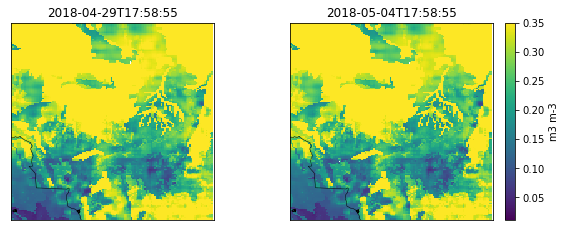

In [11]:
make_image(lon_gr,lat_gr,soil_gr,date,grosso_north, grosso_south,grosso_west, grosso_east, unit, data_later = soil_later,date_later = date_later)

Finally, let's delete files we downloaded:

In [12]:
if os.path.exists(filename_s_america):
    os.remove(filename_s_america)
if os.path.exists(filename_mato_grosso):
    os.remove(filename_mato_grosso)